In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def linear_beta_schedule(timesteps):
    return torch.linspace(1e-4, 0.02, timesteps)

T = 1000
betas = linear_beta_schedule(T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

In [3]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, base_channels=64):
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels + 1, base_channels, 3, padding=1), nn.ReLU(),
            nn.Conv2d(base_channels, base_channels, 3, padding=1), nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels * 2, 3, padding=1), nn.ReLU(),
            nn.Conv2d(base_channels * 2, base_channels * 2, 3, padding=1), nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        self.mid = nn.Sequential(
            nn.Conv2d(base_channels * 2, base_channels * 4, 3, padding=1), nn.ReLU(),
            nn.Conv2d(base_channels * 4, base_channels * 4, 3, padding=1), nn.ReLU()
        )

        self.up1 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(base_channels * 4, base_channels * 2, 3, padding=1), nn.ReLU(),
            nn.Conv2d(base_channels * 2, base_channels * 2, 3, padding=1), nn.ReLU()
        )

        self.up2 = nn.ConvTranspose2d(base_channels * 2, base_channels, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(base_channels * 2, base_channels, 3, padding=1), nn.ReLU(),
            nn.Conv2d(base_channels, base_channels, 3, padding=1), nn.ReLU()
        )

        self.out = nn.Conv2d(base_channels, in_channels, 1)

    def forward(self, x, t):
        t = t[:, None, None, None].float() / T
        t = t.expand(-1, 1, x.size(2), x.size(3))
        x = torch.cat([x, t], dim=1)
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        m = self.mid(self.pool2(e2))
        d1 = self.up1(m)
        d1 = self.dec1(torch.cat([d1, e2], dim=1))
        d2 = self.up2(d1)
        d2 = self.dec2(torch.cat([d2, e1], dim=1))
        return self.out(d2)

In [4]:
def q_sample(x_0, t, noise):
    return sqrt_alphas_cumprod[t][:, None, None, None] * x_0 + sqrt_one_minus_alphas_cumprod[t][:, None, None, None] * noise

def train_ddim(model, loader, optimizer, epochs=10, device='cuda'):
    model.train()
    train_losses = []
    for epoch in range(epochs):
        total_loss = 0
        for x, _ in tqdm(loader, desc=f"Epoch {epoch+1}"):
            x = x.to(device)
            t = torch.randint(0, T, (x.size(0),), device=device).long()
            noise = torch.randn_like(x)
            x_t = q_sample(x, t, noise)
            pred = model(x_t, t)
            loss = F.mse_loss(pred, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
        avg_loss = total_loss / len(loader.dataset)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")
    return train_losses


In [5]:
@torch.no_grad()
def ddim_sample(model, steps=50, eta=0.0):
    device = next(model.parameters()).device
    x = torch.randn((16, 3, 32, 32)).to(device)
    trajectory = []

    times = torch.linspace(T-1, 0, steps, dtype=torch.long)
    for i in range(steps):
        t = times[i].expand(x.size(0)).to(device)
        noise_pred = model(x, t)

        alpha_bar = alphas_cumprod[t].to(device)[:, None, None, None]
        sqrt_ab = torch.sqrt(alpha_bar)
        sqrt_one_minus_ab = torch.sqrt(1 - alpha_bar)

        x0_pred = (x - sqrt_one_minus_ab * noise_pred) / sqrt_ab
        if i < steps - 1:
            t_next = times[i+1].expand(x.size(0)).to(device)
            alpha_bar_next = alphas_cumprod[t_next].to(device)[:, None, None, None]
            sigma = eta * torch.sqrt((1 - alpha_bar / alpha_bar_next) * (1 - alpha_bar_next) / (1 - alpha_bar))
            noise = torch.randn_like(x) if eta > 0 else 0
            x = torch.sqrt(alpha_bar_next) * x0_pred + torch.sqrt(1 - alpha_bar_next - sigma**2) * noise_pred + sigma * noise
        else:
            x = x0_pred
        if i % 10 == 0 or i == steps - 1:
            trajectory.append(x.cpu().clone())
    return x.clamp(-1, 1).cpu(), trajectory


In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2. - 1.)
])
dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move all constants to device
betas = betas.to(device)
alphas = alphas.to(device)
alphas_cumprod = alphas_cumprod.to(device)
sqrt_alphas_cumprod = sqrt_alphas_cumprod.to(device)
sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod.to(device)

In [8]:
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

In [9]:
losses = train_ddim(model, loader, optimizer, epochs=100, device=device)

Epoch 1: 100%|██████████| 391/391 [00:08<00:00, 43.72it/s]


Epoch 1 - Loss: 0.2170


Epoch 2: 100%|██████████| 391/391 [00:07<00:00, 49.92it/s]


Epoch 2 - Loss: 0.0786


Epoch 3: 100%|██████████| 391/391 [00:07<00:00, 54.16it/s]


Epoch 3 - Loss: 0.0671


Epoch 4: 100%|██████████| 391/391 [00:07<00:00, 55.22it/s]


Epoch 4 - Loss: 0.0608


Epoch 5: 100%|██████████| 391/391 [00:08<00:00, 48.59it/s]


Epoch 5 - Loss: 0.0582


Epoch 6: 100%|██████████| 391/391 [00:08<00:00, 45.75it/s]


Epoch 6 - Loss: 0.0567


Epoch 7: 100%|██████████| 391/391 [00:07<00:00, 49.05it/s]


Epoch 7 - Loss: 0.0538


Epoch 8: 100%|██████████| 391/391 [00:08<00:00, 45.71it/s]


Epoch 8 - Loss: 0.0536


Epoch 9: 100%|██████████| 391/391 [00:08<00:00, 47.56it/s]


Epoch 9 - Loss: 0.0520


Epoch 10: 100%|██████████| 391/391 [00:07<00:00, 54.51it/s]


Epoch 10 - Loss: 0.0500


Epoch 11: 100%|██████████| 391/391 [00:08<00:00, 46.03it/s]


Epoch 11 - Loss: 0.0497


Epoch 12: 100%|██████████| 391/391 [00:08<00:00, 46.15it/s]


Epoch 12 - Loss: 0.0482


Epoch 13: 100%|██████████| 391/391 [00:08<00:00, 48.78it/s]


Epoch 13 - Loss: 0.0472


Epoch 14: 100%|██████████| 391/391 [00:08<00:00, 45.61it/s]


Epoch 14 - Loss: 0.0462


Epoch 15: 100%|██████████| 391/391 [00:08<00:00, 46.66it/s]


Epoch 15 - Loss: 0.0457


Epoch 16: 100%|██████████| 391/391 [00:07<00:00, 52.60it/s]


Epoch 16 - Loss: 0.0446


Epoch 17: 100%|██████████| 391/391 [00:08<00:00, 46.22it/s]


Epoch 17 - Loss: 0.0440


Epoch 18: 100%|██████████| 391/391 [00:08<00:00, 46.10it/s]


Epoch 18 - Loss: 0.0437


Epoch 19: 100%|██████████| 391/391 [00:07<00:00, 50.85it/s]


Epoch 19 - Loss: 0.0431


Epoch 20: 100%|██████████| 391/391 [00:08<00:00, 46.30it/s]


Epoch 20 - Loss: 0.0427


Epoch 21: 100%|██████████| 391/391 [00:08<00:00, 45.47it/s]


Epoch 21 - Loss: 0.0422


Epoch 22: 100%|██████████| 391/391 [00:08<00:00, 46.67it/s]


Epoch 22 - Loss: 0.0421


Epoch 23: 100%|██████████| 391/391 [00:08<00:00, 46.79it/s]


Epoch 23 - Loss: 0.0414


Epoch 24: 100%|██████████| 391/391 [00:07<00:00, 50.10it/s]


Epoch 24 - Loss: 0.0415


Epoch 25: 100%|██████████| 391/391 [00:08<00:00, 46.48it/s]


Epoch 25 - Loss: 0.0408


Epoch 26: 100%|██████████| 391/391 [00:08<00:00, 48.41it/s]


Epoch 26 - Loss: 0.0411


Epoch 27: 100%|██████████| 391/391 [00:08<00:00, 47.51it/s]


Epoch 27 - Loss: 0.0406


Epoch 28: 100%|██████████| 391/391 [00:08<00:00, 47.64it/s]


Epoch 28 - Loss: 0.0399


Epoch 29: 100%|██████████| 391/391 [00:07<00:00, 54.75it/s]


Epoch 29 - Loss: 0.0393


Epoch 30: 100%|██████████| 391/391 [00:07<00:00, 54.30it/s]


Epoch 30 - Loss: 0.0389


Epoch 31: 100%|██████████| 391/391 [00:07<00:00, 54.15it/s]


Epoch 31 - Loss: 0.0393


Epoch 32: 100%|██████████| 391/391 [00:07<00:00, 54.51it/s]


Epoch 32 - Loss: 0.0390


Epoch 33: 100%|██████████| 391/391 [00:08<00:00, 45.51it/s]


Epoch 33 - Loss: 0.0390


Epoch 34: 100%|██████████| 391/391 [00:08<00:00, 47.88it/s]


Epoch 34 - Loss: 0.0384


Epoch 35: 100%|██████████| 391/391 [00:08<00:00, 45.68it/s]


Epoch 35 - Loss: 0.0381


Epoch 36: 100%|██████████| 391/391 [00:08<00:00, 45.80it/s]


Epoch 36 - Loss: 0.0386


Epoch 37: 100%|██████████| 391/391 [00:08<00:00, 46.93it/s]


Epoch 37 - Loss: 0.0388


Epoch 38: 100%|██████████| 391/391 [00:07<00:00, 54.77it/s]


Epoch 38 - Loss: 0.0382


Epoch 39: 100%|██████████| 391/391 [00:08<00:00, 46.31it/s]


Epoch 39 - Loss: 0.0378


Epoch 40: 100%|██████████| 391/391 [00:07<00:00, 51.60it/s]


Epoch 40 - Loss: 0.0379


Epoch 41: 100%|██████████| 391/391 [00:08<00:00, 46.24it/s]


Epoch 41 - Loss: 0.0379


Epoch 42: 100%|██████████| 391/391 [00:08<00:00, 46.06it/s]


Epoch 42 - Loss: 0.0375


Epoch 43: 100%|██████████| 391/391 [00:08<00:00, 46.67it/s]


Epoch 43 - Loss: 0.0369


Epoch 44: 100%|██████████| 391/391 [00:07<00:00, 49.85it/s]


Epoch 44 - Loss: 0.0375


Epoch 45: 100%|██████████| 391/391 [00:08<00:00, 47.88it/s]


Epoch 45 - Loss: 0.0379


Epoch 46: 100%|██████████| 391/391 [00:07<00:00, 49.81it/s]


Epoch 46 - Loss: 0.0366


Epoch 47: 100%|██████████| 391/391 [00:08<00:00, 45.96it/s]


Epoch 47 - Loss: 0.0372


Epoch 48: 100%|██████████| 391/391 [00:07<00:00, 52.23it/s]


Epoch 48 - Loss: 0.0368


Epoch 49: 100%|██████████| 391/391 [00:07<00:00, 52.64it/s]


Epoch 49 - Loss: 0.0374


Epoch 50: 100%|██████████| 391/391 [00:07<00:00, 54.27it/s]


Epoch 50 - Loss: 0.0367


Epoch 51: 100%|██████████| 391/391 [00:07<00:00, 55.06it/s]


Epoch 51 - Loss: 0.0363


Epoch 52: 100%|██████████| 391/391 [00:08<00:00, 46.08it/s]


Epoch 52 - Loss: 0.0361


Epoch 53: 100%|██████████| 391/391 [00:08<00:00, 46.07it/s]


Epoch 53 - Loss: 0.0363


Epoch 54: 100%|██████████| 391/391 [00:08<00:00, 47.52it/s]


Epoch 54 - Loss: 0.0361


Epoch 55: 100%|██████████| 391/391 [00:07<00:00, 54.23it/s]


Epoch 55 - Loss: 0.0366


Epoch 56: 100%|██████████| 391/391 [00:08<00:00, 48.22it/s]


Epoch 56 - Loss: 0.0365


Epoch 57: 100%|██████████| 391/391 [00:08<00:00, 46.60it/s]


Epoch 57 - Loss: 0.0359


Epoch 58: 100%|██████████| 391/391 [00:08<00:00, 48.14it/s]


Epoch 58 - Loss: 0.0362


Epoch 59: 100%|██████████| 391/391 [00:07<00:00, 50.55it/s]


Epoch 59 - Loss: 0.0358


Epoch 60: 100%|██████████| 391/391 [00:08<00:00, 48.70it/s]


Epoch 60 - Loss: 0.0355


Epoch 61: 100%|██████████| 391/391 [00:08<00:00, 46.32it/s]


Epoch 61 - Loss: 0.0360


Epoch 62: 100%|██████████| 391/391 [00:07<00:00, 52.33it/s]


Epoch 62 - Loss: 0.0360


Epoch 63: 100%|██████████| 391/391 [00:07<00:00, 53.87it/s]


Epoch 63 - Loss: 0.0356


Epoch 64: 100%|██████████| 391/391 [00:08<00:00, 46.26it/s]


Epoch 64 - Loss: 0.0355


Epoch 65: 100%|██████████| 391/391 [00:08<00:00, 46.41it/s]


Epoch 65 - Loss: 0.0351


Epoch 66: 100%|██████████| 391/391 [00:07<00:00, 53.13it/s]


Epoch 66 - Loss: 0.0350


Epoch 67: 100%|██████████| 391/391 [00:07<00:00, 49.75it/s]


Epoch 67 - Loss: 0.0351


Epoch 68: 100%|██████████| 391/391 [00:08<00:00, 46.03it/s]


Epoch 68 - Loss: 0.0354


Epoch 69: 100%|██████████| 391/391 [00:08<00:00, 47.74it/s]


Epoch 69 - Loss: 0.0356


Epoch 70: 100%|██████████| 391/391 [00:08<00:00, 46.07it/s]


Epoch 70 - Loss: 0.0356


Epoch 71: 100%|██████████| 391/391 [00:07<00:00, 51.56it/s]


Epoch 71 - Loss: 0.0354


Epoch 72: 100%|██████████| 391/391 [00:08<00:00, 48.47it/s]


Epoch 72 - Loss: 0.0350


Epoch 73: 100%|██████████| 391/391 [00:08<00:00, 47.09it/s]


Epoch 73 - Loss: 0.0350


Epoch 74: 100%|██████████| 391/391 [00:07<00:00, 50.17it/s]


Epoch 74 - Loss: 0.0357


Epoch 75: 100%|██████████| 391/391 [00:08<00:00, 46.10it/s]


Epoch 75 - Loss: 0.0351


Epoch 76: 100%|██████████| 391/391 [00:08<00:00, 46.23it/s]


Epoch 76 - Loss: 0.0350


Epoch 77: 100%|██████████| 391/391 [00:07<00:00, 52.10it/s]


Epoch 77 - Loss: 0.0348


Epoch 78: 100%|██████████| 391/391 [00:08<00:00, 45.52it/s]


Epoch 78 - Loss: 0.0350


Epoch 79: 100%|██████████| 391/391 [00:08<00:00, 45.97it/s]


Epoch 79 - Loss: 0.0353


Epoch 80: 100%|██████████| 391/391 [00:08<00:00, 45.26it/s]


Epoch 80 - Loss: 0.0353


Epoch 81: 100%|██████████| 391/391 [00:08<00:00, 46.36it/s]


Epoch 81 - Loss: 0.0350


Epoch 82: 100%|██████████| 391/391 [00:08<00:00, 46.31it/s]


Epoch 82 - Loss: 0.0348


Epoch 83: 100%|██████████| 391/391 [00:08<00:00, 48.37it/s]


Epoch 83 - Loss: 0.0348


Epoch 84: 100%|██████████| 391/391 [00:08<00:00, 46.33it/s]


Epoch 84 - Loss: 0.0348


Epoch 85: 100%|██████████| 391/391 [00:07<00:00, 49.80it/s]


Epoch 85 - Loss: 0.0347


Epoch 86: 100%|██████████| 391/391 [00:08<00:00, 48.20it/s]


Epoch 86 - Loss: 0.0345


Epoch 87: 100%|██████████| 391/391 [00:07<00:00, 52.02it/s]


Epoch 87 - Loss: 0.0345


Epoch 88: 100%|██████████| 391/391 [00:08<00:00, 45.90it/s]


Epoch 88 - Loss: 0.0344


Epoch 89: 100%|██████████| 391/391 [00:07<00:00, 50.58it/s]


Epoch 89 - Loss: 0.0350


Epoch 90: 100%|██████████| 391/391 [00:08<00:00, 46.66it/s]


Epoch 90 - Loss: 0.0346


Epoch 91: 100%|██████████| 391/391 [00:08<00:00, 46.62it/s]


Epoch 91 - Loss: 0.0342


Epoch 92: 100%|██████████| 391/391 [00:07<00:00, 52.55it/s]


Epoch 92 - Loss: 0.0343


Epoch 93: 100%|██████████| 391/391 [00:08<00:00, 46.04it/s]


Epoch 93 - Loss: 0.0346


Epoch 94: 100%|██████████| 391/391 [00:08<00:00, 47.85it/s]


Epoch 94 - Loss: 0.0350


Epoch 95: 100%|██████████| 391/391 [00:07<00:00, 52.87it/s]


Epoch 95 - Loss: 0.0349


Epoch 96: 100%|██████████| 391/391 [00:08<00:00, 46.48it/s]


Epoch 96 - Loss: 0.0344


Epoch 97: 100%|██████████| 391/391 [00:07<00:00, 52.94it/s]


Epoch 97 - Loss: 0.0347


Epoch 98: 100%|██████████| 391/391 [00:07<00:00, 49.81it/s]


Epoch 98 - Loss: 0.0348


Epoch 99: 100%|██████████| 391/391 [00:08<00:00, 46.45it/s]


Epoch 99 - Loss: 0.0344


Epoch 100: 100%|██████████| 391/391 [00:07<00:00, 54.00it/s]

Epoch 100 - Loss: 0.0342


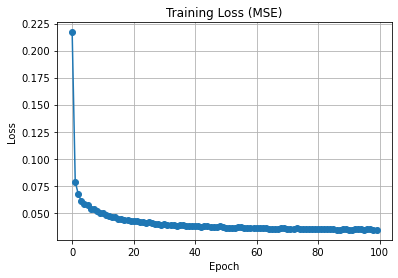

In [10]:
plt.figure(figsize=(6, 4))
plt.plot(losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss (MSE)")
plt.grid(True)
plt.show()

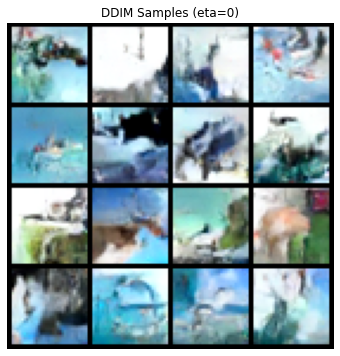

In [11]:
samples, traj = ddim_sample(model, steps=50, eta=0.0)
grid = make_grid(samples, nrow=4, normalize=True)
plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title("DDIM Samples (eta=0)")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


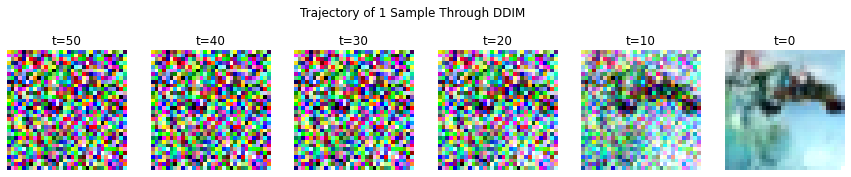

In [12]:
# Visualize trajectory of the first sample
plt.figure(figsize=(15, 3))
for i, img in enumerate(traj):
    plt.subplot(1, len(traj), i + 1)
    plt.imshow((img[0].permute(1, 2, 0) + 1) / 2)
    plt.axis("off")
    plt.title(f"t={50 - i*10}")
plt.suptitle("Trajectory of 1 Sample Through DDIM")
plt.show()
